# Financial Network

**Author**: [Erika Fille Legara](http://www.erikalegara.net/)

You are free to use (or change) this notebook for any purpose you'd like. However, please respect the MIT License that governs its use, and for copying permission.

Copyright © 2016 Erika Fille Legara

---
## Description
I have been receiving requests to release the Python code I wrote to produce the financial network discussed in my blog post at [erikafille.ph](http://erikafille.ph) titled [PSE Correlation-Based Network](https://erikafille.ph/2016/08/16/pse-correlation-based-network/). Here it is. 

In this notebook, we build a correlation-based network (minimum spanning tree (MST)) of companies listed in the [Philippine Stock Exchange](https://www.pse.com.ph/stockMarket/home.html). The entire process can be summarized into three steps:
1. Set up the **correlation matrix** for the stock prices in the Philippine Stock Exchange.
2. Convert the resulting correlation matrix into a **distance matrix**.
3. Build a **minimum spanning tree** from the distance matrix.

### Data
I got the link to the data from this [stock forum post](http://www.stockmarketpilipinas.com/thread-500.html). In this post it says [Drop Box: 2006-present worth of CSV files uploaded by Mr. Coelacanth](https://www.dropbox.com/sh/1dluf0lawy9a7rm/fHREemAjWS). The last I checked, the 2016 historical dataset is only until the 15th of July. 

---
## Let's Dig In
Import the necessary packages.

In [1]:
from __future__ import division

try:
    import networkx as nx
    import pandas as pd
    import os
    import matplotlib.pyplot as plt
    import seaborn as sns
    import math
    import numpy as np
    from datetime import datetime
    %matplotlib inline
    
except:
    import traceback
    traceback.print_exc()
    raise ImportError('Something failed, see above.')

### Load Data
We first load the list of companies in the PSE and store it in a Pandas data frame we call `pse_companies`.

In [2]:
pse_companies = pd.read_csv("PSE-listed-companies.csv")
pse_companies = pse_companies[["Company Name", "Stock Symbol", "Sector", "Subsector", "Listing Date"]]
pse_companies.head()

,Company Name,Stock Symbol,Sector,Subsector,Listing Date
0,"Unioil Resources & Holdings Company, Inc.",UNI,Holding Firms,Holding Firms,27 July 1987
1,"Union Bank of the Philippines, Inc.",UBP,Financials,Banks,29 June 1992
2,United Paragon Mining Corporation,UPM,Mining and Oil,Mining,2 April 1973
3,Universal Robina Corporation,URC,Industrial,"Food, Beverage & Tobacco",25 March 1994
4,"Uniwide Holdings, Inc.",UW,Property,Property,19 August 1996


Then, load all files under the folder "2016" to load all 2016 data. Each file inside a folder contains the prices of all stock quotes in the PSE for the day (as indicated in the filename). As mentioned, the dataset I have for the year 2016 only runs until the 15th of July. 

The cell block below loads all files in the directory `"./2016/"`.

In [3]:
files2016 = os.listdir("./2016/")

Let's now explore the content of a file (stock prices for 1 day) inside the directory (folder). 

*I am not exactly sure what the last two columns are, so I'm assigning them the variables X1 and X2, respectively.*

In [4]:
print "Day: ", files2016[0]
df0 = pd.read_csv("./2016/" + files2016[0], header=None)
df0.head()

Day:  stockQuotes_01042016.csv


,0,1,2,3,4,5,6,7
0,^FINANCIAL,01/04/2016,1554.07,1555.61,1531.13,1531.13,298140,59289
1,AUB,01/04/2016,46.30,46.30,45.00,46.15,12900,411515
2,BDO,01/04/2016,106.00,106.00,101.90,101.90,551000,10878135
3,BPI,01/04/2016,83.70,83.75,83.00,83.20,384540,9318360
4,CHIB,01/04/2016,37.50,37.50,37.05,37.05,33200,193819


In [5]:
df0.columns = ["Company_Index", "Date", "Open", "High", "Low", "Close", "X1", "X2"]
df0.head()

,Company_Index,Date,Open,High,Low,Close,X1,X2
0,^FINANCIAL,01/04/2016,1554.07,1555.61,1531.13,1531.13,298140,59289
1,AUB,01/04/2016,46.30,46.30,45.00,46.15,12900,411515
2,BDO,01/04/2016,106.00,106.00,101.90,101.90,551000,10878135
3,BPI,01/04/2016,83.70,83.75,83.00,83.20,384540,9318360
4,CHIB,01/04/2016,37.50,37.50,37.05,37.05,33200,193819


After my initial data exploration, I made a list of companies I am discarding in this analysis. I am also excluding the indices. In any case, you may add or delete stocks to your liking.

In [6]:
pse_comp = list(pse_companies["Stock Symbol"])
discard = ['UW', 'VMC', 'VVT', 'PRIM', 'MJIC', 'MACAY', 'PMT', 'REG', 'ROX', \
           'RCI', 'SPC', 'SPM', 'STR', 'STN', 'SRDC', 'SGP', 'MAH', 'MGH', \
           'NXGEN', 'PCP', 'PMPC', 'PAX', 'PHC', 'H2O', 'PNC', 'PRC', 'PTT', \
           'PTC', 'PORT', 'GPH', 'GREEN', 'KPH', 'LMG', 'LSC', 'CHP', 'CAT', \
           'CIP', 'CSB', 'DWC', 'ECP', 'EVER', 'EIBA', 'FEU', 'FFI', 'FYN', \
           'FAF', 'ABC', 'AAA', 'ATI', 'AB', 'BH', 'CHI', 'CPV', "BCOR"]
companies = [company for company in pse_comp if company not in discard ]
print companies

['UNI', 'UBP', 'UPM', 'URC', 'V', 'VLL', 'VITA', 'VUL', 'WPI', 'WIN', 'X', 'YEHEY', 'ZHI', 'IPO', 'PHN', 'PNX', 'PSPC', 'PHA', 'PLC', 'POPI', 'PRMX', 'PPC', 'PGOLD', 'RFM', 'RCB', 'RLC', 'RRHI', 'ROCK', 'SBS', 'SM', 'SMPH', 'SOC', 'SSI', 'STI', 'SMC', 'PF', 'SECB', 'SCC', 'SHNG', 'SGI', 'SPH', 'SLI', 'SLF', 'SUN', 'SFI', 'T', 'PSE', 'OV', 'TFHI', 'TA', 'TAPET', 'TBGI', 'RWM', 'MJC', 'MA', 'MWC', 'MFC', 'MARC', 'MAXS', 'MWIDE', 'MEG', 'MCP', 'MPI', 'MRSGI', 'MBT', 'MG', 'NRCP', 'NI', 'NIKL', 'NOW', 'OM', 'ORE', 'OPM', 'PAL', 'TEL', 'TFC', 'LOTO', 'PA', 'PIP', 'PERC', 'PCOR', 'WEB', 'PX', 'PXP', 'PBC', 'PBB', 'PHES', 'PNB', 'RLT', 'PSB', 'SEVN', 'GTCAP', 'GSMI', 'FNI', 'GERI', 'GLO', 'HVN', 'TUGS', 'HLCM', 'HI', 'I', 'EG', 'IPM', 'IRC', 'ISM', 'IMP', 'IMI', 'ICT', 'ION', 'IS', 'IDC', 'JGS', 'JAS', 'JFC', 'JOH', 'KEP', 'LBC', 'LTG', 'LR', 'LC', 'LFM', 'LIB', 'LIHC', 'LPZ', 'MED', 'MRC', 'MHC', 'MVC', 'MAC', 'MFIN', 'MBC', 'MB', 'MER', 'CEU', 'CNPF', 'CPM', 'CPG', 'CHIB', 'TECH', 'LAND', '

We then filter the dataframe to companies listed in `companies`. We also drop the other columns and only retain the following  `["Company_Index", "Date", "Close"]` columns

In [7]:
allprices = pd.DataFrame()
for f in files2016:
    df = pd.read_csv("./2016/" + f, header=None)
    df.columns = ["Company_Index", "Date", "Open", "High", "Low", "Close", "Volume1", "Volume2"]
    df = df[df.Company_Index.isin(companies)]
    df.Date = pd.to_datetime(df.Date)
    df = df[["Company_Index", "Date", "Close"]]
    allprices = pd.concat([allprices,df], ignore_index = True)

In [8]:
allprices.head()

,Company_Index,Date,Close
0,AUB,2016-01-04,46.15
1,BDO,2016-01-04,101.90
2,BPI,2016-01-04,83.20
3,CHIB,2016-01-04,37.05
4,EW,2016-01-04,18.22


In [9]:
## List of all comapnies we are considering in this notebook

print set(list(allprices.Company_Index))

set(['PXP', 'CPM', 'AGI', 'BC', 'JFC', 'AGF', 'POPI', 'FMETF', 'CPG', 'RWM', 'IDC', 'SCC', 'BMM', 'PAL', 'FNI', 'MED', 'PERC', 'RRHI', 'LIB', 'GMA7', 'GERI', 'CROWN', 'SPH', 'ION', 'LBC', 'MFIN', 'YEHEY', 'PIP', 'LR', 'WEB', 'LPZ', 'URC', 'VITA', 'OM', 'GMAP', 'GSMI', '2GO', 'T', 'PGOLD', 'X', 'MRC', 'APX', 'UBP', 'PHN', 'SMPH', 'HOUSE', 'PHA', 'CDC', 'IPO', 'IPM', 'MAC', 'APO', 'SFI', 'APC', 'TBGI', 'FDC', 'DMC', 'BEL', 'AEV', 'MWC', 'HI', 'EEI', 'EMP', 'GTCAP', 'MFC', 'VLL', 'PX', 'CEI', 'PRMX', 'CEU', 'PA', 'PF', 'GEO', 'EG', 'UPM', 'BLFI', 'FOOD', 'BDO', 'CNPF', 'STI', 'PHES', 'TUGS', 'NRCP', 'PBC', 'PBB', 'ABSP', 'EW', 'JGS', 'RFM', 'MG', 'MA', 'OV', 'PSB', 'MWIDE', 'MPI', 'AR', 'HLCM', 'ANS', 'OPM', 'NOW', 'AT', 'TAPET', 'ACE', 'GLO', 'ATN', 'SUN', 'VUL', 'ACR', 'PCOR', 'ISM', 'CHIB', 'FJP', 'SMC', 'COL', 'LAND', 'NI', 'ALHI', 'SECB', 'TEL', 'DMPL', 'LFM', 'TECH', 'WPI', 'BKR', 'ICT', 'BSC', 'AUB', 'IMI', 'DNL', 'COSCO', 'JOH', 'MVC', 'LTG', 'SBS', 'V', 'UNI', 'FLI', 'EURO', 'EDC

In the variable `subset` below, we further filter the dataset by date range. Here, I only want to look at the prices from January 01, 2016 to the end of July. I then reshape the data frame `subset` and store it in the variable `final_df` where the columns are the assets and the rows are the prices of the assets on a particular day.

In [10]:
subset = allprices[(allprices.Date > datetime(2016,1,1,0,0,0)) & (allprices.Date < datetime(2016,7,31,23,59,59))]
final_df = subset.pivot(index="Date", columns="Company_Index", values="Close")

In [11]:
final_df.head()

Company_Index,2GO,ABA,ABG,ABS,ABSP,AC,ACE,ACR,AEV,AGF,...,V,VITA,VLL,VUL,WEB,WIN,WPI,X,YEHEY,ZHI
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,7.00,0.370,10.30,62.40,64.0,756,NaN,1.38,57.20,2.80,...,3.20,0.59,5.00,1.05,23.0,NaN,NaN,15.62,4.10,NaN
2016-01-05,6.91,0.370,10.28,62.30,63.0,742,NaN,1.37,57.75,2.71,...,1.83,0.59,5.00,1.08,22.7,0.21,0.33,15.52,4.12,0.250
2016-01-06,6.80,0.365,10.20,62.00,62.6,732,1.14,1.39,57.90,2.58,...,1.80,0.62,4.97,1.06,21.5,NaN,0.34,15.20,3.88,NaN
2016-01-07,6.63,0.370,10.22,61.75,62.1,709,1.15,1.36,56.00,2.65,...,1.76,0.58,4.82,1.03,21.0,0.20,0.33,14.48,3.62,0.231
2016-01-08,6.55,0.360,10.18,61.10,62.0,700,1.12,1.35,56.30,2.50,...,1.70,0.56,4.93,1.06,21.0,0.19,0.32,14.64,3.38,0.231


---
### Step 1: Build Correlation Matrix
From the data frame above, we now build the **correlation matrix**.
<blockquote>In finance/stock trading, **correlation** is just a measure of the extent at which two equities behave with respect to each other.</blockquote>
Below, we build the correlation matrix from `final_df` and store it in the variable `price_corr`. The matrix provides us with the corresponding **correlation coefficients (-1.0 to +1.0)** for all stock pairs in the list of companies. [Straightforward](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html), isn't it? 

In [12]:
price_corr = final_df.corr()

When two assets are *positively correlated*, it means that the general trends of the two stocks are similar; when one goes up, the other one goes up as well. When, on the other hand, two assets are *negatively correlated*, their trends go in opposite directions. 

I made a quick sketch below to illustrate these relationships. 

![alt text](./img/corr.png "Correlation")

For a more concrete example, let us have a look at the relationships between (`$ABS` and `$ACR`), (`$FMETF` and `$ALI`) and (`$BLOOM` and `$BDO`); the `$` sign is the hashtag used for stock quotes. I chose these securities based on the correlation values of the pairs in `price_corr`. Can you tell which of the pairs are positively correlated? Negatively correlation?

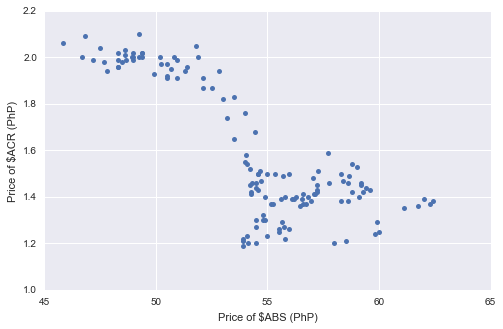

In [13]:
## ABS and ACR
plt.figure(figsize=(8,5))
plt.plot(final_df['ABS'], final_df["ACR"], '.', markersize=10)
plt.xlabel("Price of $ABS (PhP)")
plt.ylabel("Price of $ACR (PhP)")
_ = plt.show()

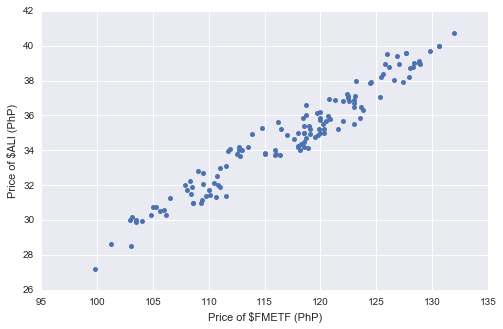

In [14]:
## FMETF and ALI

plt.figure(figsize=(8,5))
plt.plot(final_df['FMETF'], final_df["ALI"], '.', markersize=10)
plt.xlabel("Price of $FMETF (PhP)")
plt.ylabel("Price of $ALI (PhP)")
_ = plt.show()

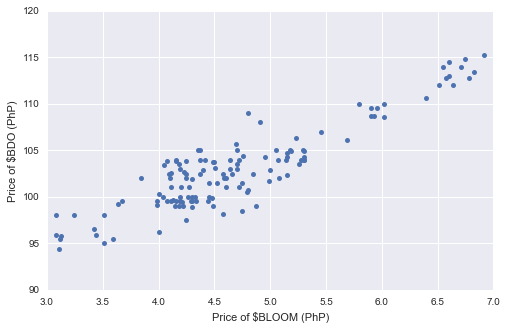

In [15]:
## BLOOM and BDO

plt.figure(figsize=(8,5))
plt.plot(final_df['BLOOM'], final_df["BDO"], '.', markersize=10)
plt.xlabel("Price of $BLOOM (PhP)")
plt.ylabel("Price of $BDO (PhP)")
_ = plt.show()

Below, we draw the heatmap of the resulting correlation matrix.

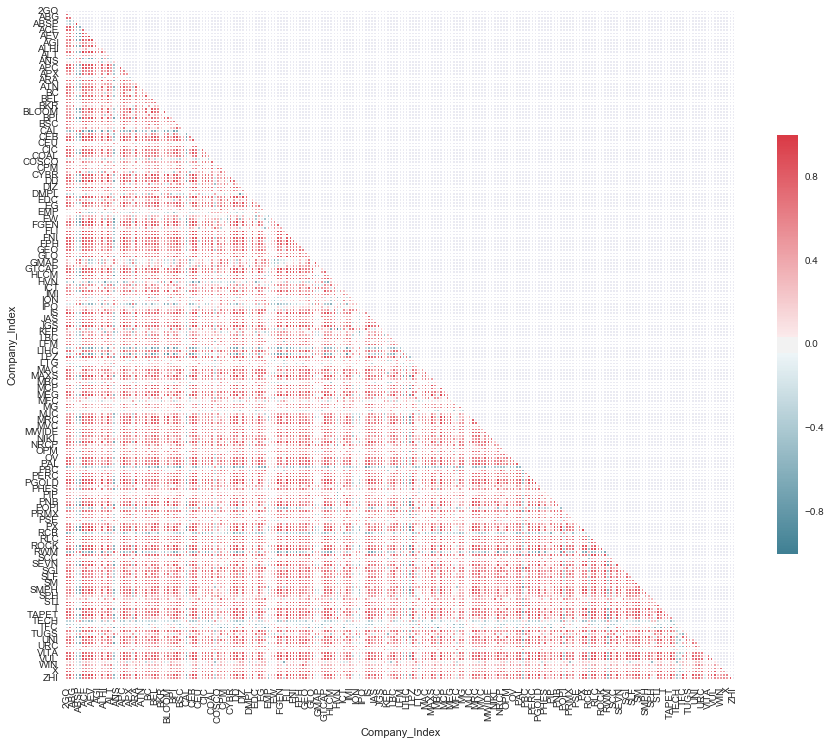

In [16]:
## Source: https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html

## Generate a mask for the upper triangle
mask = np.zeros_like(price_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

## Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

## Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

## Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(price_corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=2, yticklabels=2,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

_ = plt.show()

---
### Step 2: Build Distance Matrix
As mentioned in the blog post, we will use two distance metrics in building the distance matrices. The first metric is from Bonanno et al.

\begin{equation}d_{ij} = \sqrt{2 \times (1 - c_{ij})}\end{equation}

where $c_{ij}$ is the correlation cofficient of stocks $i$ and $j$. In the equation, when $c_{ij}=1$, $d_{ij}=0$; and, when $c_{ij}=-1$, $d_{ij}=2$. That is, when there is a perfectly positive correlation (+1), the distance is 0; and, when the correlation is perfectly negative, the distance is the farthest at 2. The next distance measure is from [SliceMatrix](http://SliceMatrix.com) (mktstk) and it is given by

\begin{equation}d_{ij} = 1 - |c_{ij}|.\end{equation}

This equation does not distinguish between a positively or a negatively correlated pair of stocks; as long as two stocks are highly correlated, the distance is minimized. 

Here, we define the distance matrices as `dist_bonanno` and `dist_mktstk`.

In [17]:
dist_bonanno = np.sqrt(2*(1-(price_corr)))
dist_mktstk = 1-abs(price_corr)

## I am just defining the labels
labs_bonanno = list(dist_bonanno.index)
labs_mktstk = list(dist_mktstk.index)

---
### Step 3: Build Minimum Spanning Tree (MST)

Now, we are ready to build the minimum spanning tree. The idea is to connect the ones that have the closest distance to each other, i.e. connect those that are highly correlated. Let's first build the "weighted" networks `G_bonanno` and `G_mktstk` from the distance matrices `dist_bonanno` and `dist_mktstk`, respectively. Using the Python package NetworkX, that's pretty straightforward to do.

In [18]:
G_bonanno = nx.from_numpy_matrix(dist_bonanno.as_matrix())
G_mktstk = nx.from_numpy_matrix(dist_mktstk.as_matrix())

Once we have the distance networks, we can already build minimum spanning trees (MST). Here, we use Kruskal's algorithm. Below is the pseudo-code copied from the Wikipedia entry on the algorithm.

<pre>
KRUSKAL(G):
1 A = ∅
2 foreach v ∈ G.V:
3    MAKE-SET(v)
4 foreach (u, v) in G.E ordered by weight(u, v), increasing:
5    if FIND-SET(u) ≠ FIND-SET(v):
6       A = A ∪ {(u, v)}
7       UNION(u, v)
8 return A
</pre>

Again, we can use NetworkX to build the MST with the graphs as inputs.

In [19]:
MST_b = nx.minimum_spanning_tree(G_bonanno)  
MST_m = nx.minimum_spanning_tree(G_mktstk) 

Finally, let's add more attributes to the "nodes" or the stocks. The attributes that I want to include here are: 

- `label` (the stock symbol)
- `sector` (which sector the stock belongs)
- `change` (the $\%$ change of the stock for the period under study)

This way, when we draw the MSTs, we can choose to color the nodes by either `sector` or `change`.

In [20]:
change = (final_df.iloc[-1] - final_df.iloc[0]) * 100 / final_df.iloc[0]

In [21]:
for node in MST_b.nodes():
    sector = pse_companies[pse_companies["Stock Symbol"] == labs_bonanno[node]].Sector.iloc[0]
    MST_b.node[node]["sector"] = sector
    MST_b.node[node]["label"] = labs_bonanno[node]
    if math.isnan(change[labs_bonanno[node]]):
        MST_b.node[node]["color"] = "black"
    elif change[labs_bonanno[node]] < -10:
        MST_b.node[node]["color"] = "red"
    elif change[labs_bonanno[node]] > 10:
        MST_b.node[node]["color"] = "green"
    else:
        MST_b.node[node]["color"] = "blue"

In [22]:
for node in MST_m.nodes():
    sector = pse_companies[pse_companies["Stock Symbol"] == labs_mktstk[node]].Sector.iloc[0]
    MST_m.node[node]["sector"] = sector
    MST_m.node[node]["label"] = labs_mktstk[node]
    if math.isnan(change[labs_mktstk[node]]):
        #print change[labs_mktstk[node]], labs_mktstk[node]
        #Gm.node[node]["change"] = 101
        MST_m.node[node]["color"] = "black"
    elif change[labs_mktstk[node]] < -10:
        MST_m.node[node]["color"] = "red"
    elif change[labs_mktstk[node]] > 10:
        MST_m.node[node]["color"] = "green"
    else:
        MST_m.node[node]["color"] = "blue"

### Drawing the MSTs

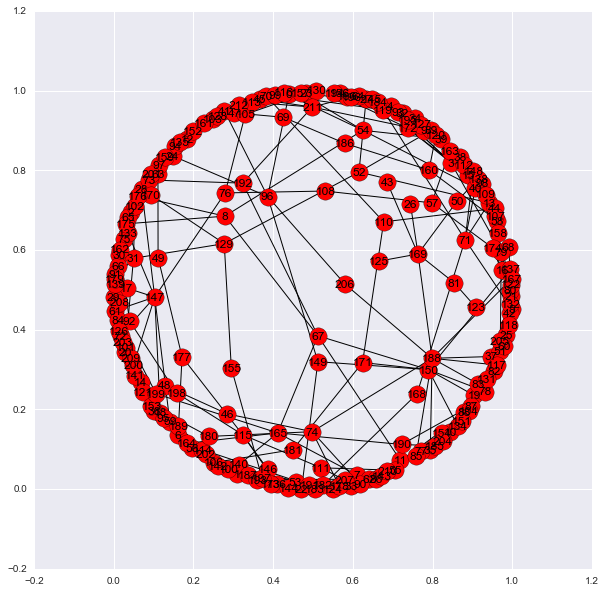

In [23]:
plt.figure(figsize=(10,10))
nx.draw_networkx(MST_b)

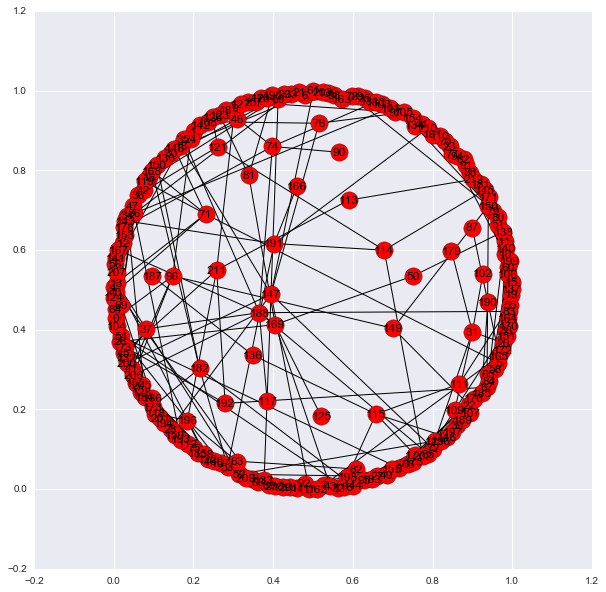

In [24]:
plt.figure(figsize=(10,10))
nx.draw_networkx(MST_m)

### Write out MSTs
Below, we write the MSTs as `gexf` files so we can use them in Gephi to generate much prettier networks/trees. 

In [25]:
nx.write_gexf(MST_b, "corrmat_bonanno.gexf")
nx.write_gexf(MST_m, "corrmat_mktstk.gexf")

Below is the resulting network (`MST_b`) drawn using Gephi.
![MST Bonanno](./img/mst_bonanno.png "MST Bonanno")